# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, а качество моделей машинного обучения не ухудшилось. Обоснуем корректность его работы. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
# отключим предупреждающие уведомления
import warnings
warnings.filterwarnings('ignore')

# Добавим основные библиотеки
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None
plt.style.use('dark_background')

In [2]:
# Импортируем датасеты методом try/except и установим индексом столбец date
pth1 = '/datasets/insurance.csv'
pth2 = 'https://code.s3.yandex.net/datasets/insurance.csv'
    
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    print('df is loaded from the address: /datasets/insurance.csv')
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
    print('df is loaded from the address: https://code.s3.yandex.net/datasets/insurance.csv')
else:
    print('error: wrong path')

df is loaded from the address: /datasets/insurance.csv


In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.00,49600.00,1,0
1,0,46.00,38000.00,1,1
2,0,29.00,21000.00,0,0
3,0,21.00,41700.00,2,0
4,1,28.00,26100.00,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.00,5000.00,5000.00,5000.00,5000.00
mean,0.50,30.95,39916.36,1.19,0.15
std,0.50,8.44,9900.08,1.09,0.46
min,0.00,18.00,5300.00,0.00,0.00
25%,0.00,24.00,33300.00,0.00,0.00
50%,0.00,30.00,40200.00,1.00,0.00
75%,1.00,37.00,46600.00,2.00,0.00
max,1.00,65.00,79000.00,6.00,5.00


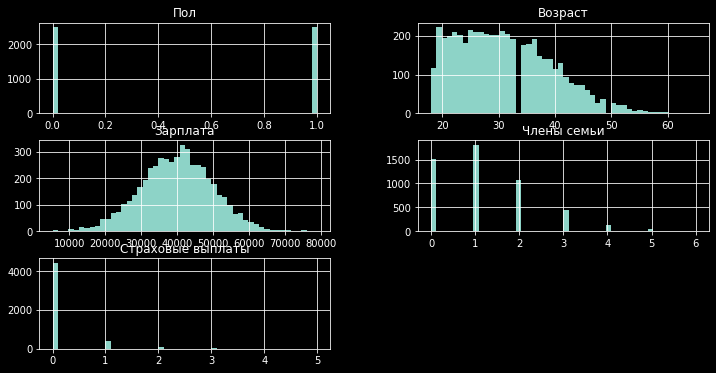

In [6]:
df.hist(bins=50, figsize=(12, 6));

Данные осмотрены. Пропусков нет, анамалий не обнаружено, с данными можно работать

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $O$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)
 - a. Изменится. Приведите примеры матриц.
 - b. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

**Ответ:** 
- b. Не изменится.

**Обоснование:** 

Признаки $X$ умножаем на обратимую матрцу $O$, обозначим результат как $M$

$$ M = XO $$

Вычислим чему будут равны предсказания при условии замены $X$ на $M$

$$ a_1 = Mw_1 $$

Задача обучения при этом станет выглядеть так:

$$ w_1 = (M^TM)^{-1} M^Ty $$

Для обоснования нам потребуется понимание следующих свойств матриц:

$$ (AB)^{-1} = B^{-1}A^{-1} $$
$$ (ABC)^{-1} = C^{-1} B^{-1} A^{-1} $$
$$ (AB)^T = B^TA^T $$
$$ AA^{-1} = A^{-1} A = E $$ 
$$ AE = EA = A $$ 

Теперь представим нашу формулу предсказания с заменой параметров, но в полном виде

$$ w_1 = ((XO)^TXO)^{-1} (XO)^Ty $$

Используя указанные выше свойства матриц, поочерёдно раскроем скобки

$$ w_1 = ((XO)^TXO)^{-1}(XO)^Ty = (O^TX^TXO)^{-1}O^TX^Ty = O^{-1}(X^T X)^{-1}(O^T)^{-1}O^TX^Ty $$

Далее сокращаем $(O^T)^{-1}O^T$

$$ w_1 = O^{-1}(X^T X)^{-1}X^Ty $$

Можно заметить что в правой части формулы мы получили $(X^T X)^{-1}X^Ty$, что является формулой обучения $w$

$$ w_1 = O^{-1}w $$

соответственно

$$ a_1 = Mw_1 $$

Подставляем $XO$ вместо $M$, обратные матрицы сокращаются

$$ a_1 = XOO^{-1}w = Xw = a $$

$$ a_1 = a $$

Что и требовалось доказать. Из продемонстрированного наглядно видно почему обратимость матрицы является необходимым условием

## Алгоритм преобразования

**Алгоритм**

1. Сгенерируем рандомную квадратную матрицу $O$ размерностью в ширину наших признаков
2. Проверим матрицу $O$ на обратимость (в случае необратимости матрицы, повторить шаг 1)
3. Помножим наши признаки $X$ на матрицу $O$ $(M = XO)$ 
4. Применим преобразованные параметры в дальнейшем алгоритме

**Обоснование**

Размерность матрицы $O$ должна быть $(n,n)$, при $n$ равной количеству признаков. Тогда матрица $M$ будет такой же размерности что и матрица оригинальных признаков $X$. Обратная матрица  существует только для квадратных невырожденных матриц (определитель которых не равен нулю).

рассмотрим на примере:

In [7]:
np.random.seed(1337)
X = np.random.randint(1,10,(6,3))
O = np.random.randint(1,10,(3,3))
M = X @ O

print('Матрица X')
print(X)
print()
print('Матрица O')
print(O)
if np.linalg.det(O) != 0:
    print('Детерминант матрицы =', np.linalg.det(O))
    print('Матрица обратима')
else:
    print('Детерминант матрицы =', np.linalg.det(O))
    print('Матрица необратима')
print()
print('Матрица M')
print(M)

Матрица X
[[8 9 8]
 [8 3 3]
 [5 9 7]
 [7 8 9]
 [2 7 7]
 [3 3 9]]

Матрица O
[[2 8 4]
 [2 4 4]
 [5 9 9]]
Детерминант матрицы = 8.000000000000002
Матрица обратима

Матрица M
[[ 74 172 140]
 [ 37 103  71]
 [ 63 139 119]
 [ 75 169 141]
 [ 53 107  99]
 [ 57 117 105]]


In [8]:
np.random.seed(1337)
y = np.array([1,2,3,4,5,6])
w = np.linalg.inv(X.T @ X) @ X.T @ y
a = X @ w
w1 = np.linalg.inv(M.T @ M) @ M.T @ y
a1 = M @ w1

print('Целевые признаки', y)
print('Вес признаков', w)
print('Предсказание', a)
print('Вес зашифрованных признаков', w1)
print('Предсказание из зашифрованных признаков', a1)
print()
print('Проверяем на разных этапах преобразования формулы. Если они равны, значит всё верно')
print('Вес зашифрованных признаков')
print(w1)
print(np.linalg.inv(M.T @ M) @ M.T @ y)
print(np.linalg.inv(((X @ O).T) @ (X @ O)) @ (X @ O).T @ y)
print(np.linalg.inv(O.T @ X.T @ X @ O) @ O.T @ X.T @ y)
print(np.linalg.inv(O) @ np.linalg.inv(X.T @ X) @ np.linalg.inv(O.T) @ O.T @ X.T @ y)
print(np.linalg.inv(O) @ np.linalg.inv(X.T @ X) @ X.T @ y)
print(np.linalg.inv(O) @ w)

Целевые признаки [1 2 3 4 5 6]
Вес признаков [-0.13494351 -0.28343227  0.8210042 ]
Предсказание [2.93759511 0.53316771 2.52142144 4.1769751  3.49311652 6.13391048]
Вес зашифрованных признаков [ 2.91745361  0.03712219 -1.56670706]
Предсказание из зашифрованных признаков [2.93759511 0.53316771 2.52142144 4.1769751  3.49311652 6.13391048]

Проверяем на разных этапах преобразования формулы. Если они равны, значит всё верно
Вес зашифрованных признаков
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]


## Проверка алгоритма

In [9]:
X = df.drop('Страховые выплаты', axis=1)
y = df['Страховые выплаты']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=1337)

print('Размер тренировочной выборки:')
print(f'признаки {X_train.shape};')
print(f'целевой признак {y_train.shape}')
print(f'это {round((y_train.count() / y.count()) * 100)}% от датасета')
print()
print('Размер тестовой выборки:')
print(f'признаки {X_test.shape};')
print(f'целевой признак {y_test.shape}')
print(f'это {round((y_test.count() / y.count()) * 100)}% от датасета')

Размер тренировочной выборки:
признаки (3750, 4);
целевой признак (3750,)
это 75% от датасета

Размер тестовой выборки:
признаки (1250, 4);
целевой признак (1250,)
это 25% от датасета


In [10]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = r2_score(y_test, pred)

print('R2 score модели =', round(score, 2))


R2 score модели = 0.43


Напишем формулу шифрования данных

In [12]:
def crypto(X):
    n = X.shape[1]
    np.random.seed(1337)
    crypto_mx = np.random.randint(1, 10, (n,n))
    det = np.linalg.det(crypto_mx)
    tryes_counter = 0
    while det == 0:
        tryes_counter += 1
        np.random.seed(1337 + tryes_counter)
        crypto_mx = np.random.randint(1, 10, (n,n))
        det = np.linalg.det(crypto_mx)
    crypted_X = X @ crypto_mx
    return crypted_X, crypto_mx

Зашифруем наши признаки и убедимся что всё сработало выведя первые строки таблиц и ключ шифрования

In [13]:
crypted_X, crypto_mx = crypto(X)

print('Признаки до шифровки')
display(X.head())
print()
print('Признаки после шифровки')
display(crypted_X.head())
print()
print('матрица/ключ шифровки')
crypto_mx

Признаки до шифровки


,Пол,Возраст,Зарплата,Члены семьи
0,1,41.00,49600.00,1
1,0,46.00,38000.00,1
2,0,29.00,21000.00,0
3,0,21.00,41700.00,2
4,1,28.00,26100.00,0



Признаки после шифровки


,0,1,2,3
0,347333.00,347339.00,397020.00,446780.00
1,266140.00,266145.00,304237.00,342417.00
2,147087.00,147087.00,168145.00,189261.00
3,291967.00,291977.00,333719.00,375495.00
4,182792.00,182793.00,208948.00,235160.00



матрица/ключ шифровки


array([[8, 9, 8, 8],
       [3, 3, 5, 9],
       [7, 7, 8, 9],
       [2, 7, 7, 3]])

In [14]:
crypted_X_train, crypted_X_test, y_train, y_test = train_test_split(
        crypted_X, y, test_size=0.25, random_state=1337)

model = LinearRegression()
model.fit(crypted_X_train, y_train)
pred = model.predict(crypted_X_test)
crypted_score = r2_score(y_test, pred)

print('R2 score модели =', round(crypted_score, 2))

R2 score модели = 0.43


In [15]:
scores_names = ['обычные данные', 
                'зашифрованные данные'  
               ]
scores = [score,
          crypted_score
         ]

results = pd.DataFrame({'Тип':scores_names,
                        'Значение R2':crypted_score
                        })

## Вывод

Пройденные этапы:
- Загружены и изучены данные
- Теоретически обосновано что при умножении данных на обратимую матрицу, качество работы линейной регрессии не изменится
- Предложен алгоритм преобразования данных
- Предложен алгоритм преобразования данных
- Алгоритм проверен на практике и показал что теоретическия верна

In [16]:
print('Признаки до шифровки')
display(X.head())
print()
print('Признаки после шифровки')
display(crypted_X.head())

results

Признаки до шифровки


,Пол,Возраст,Зарплата,Члены семьи
0,1,41.00,49600.00,1
1,0,46.00,38000.00,1
2,0,29.00,21000.00,0
3,0,21.00,41700.00,2
4,1,28.00,26100.00,0



Признаки после шифровки


,0,1,2,3
0,347333.00,347339.00,397020.00,446780.00
1,266140.00,266145.00,304237.00,342417.00
2,147087.00,147087.00,168145.00,189261.00
3,291967.00,291977.00,333719.00,375495.00
4,182792.00,182793.00,208948.00,235160.00


,Тип,Значение R2
0,обычные данные,0.43
1,зашифрованные данные,0.43


Как видно метрика R2 в обоих случаях одинакова, а данные пользователей надёжно зашифрованы